In [10]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np

from pathlib import Path
from dotenv import load_dotenv

import os

from scipy import ndimage
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
from yolov5.utils.plots import Annotator, save_one_box

from utils.preprocess import recovery_rotated_bounding
from utils.yolo import get_teeth_ROI, crop_by_xyxy
from utils.edge import gum_jaw_separation, vertical_separation, get_rotation_angle, consecutive

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

%matplotlib inline

# TODO 008140 008225 tooth missing


In [11]:
model = torch.hub.load(r'..\YOLO', 'custom', path=r'..\YOLO\weights\8-bound.pt', source='local')
tooth_position_dict = {
    0: 'left',
    1: 'middle',
    2: 'right'
}
all_tooth_number_dict = {
    'upper': {
        'left': {0: 16, 1: 15, 2: 14},
        'middle': {0: 12, 1: 11, 2: 21, 3: 22},
        'right': {0: 24, 1: 25, 2: 26},
    },
    'lower': {
        'left': {0: 46, 1: 45, 2: 44},
        'middle': {0: 42, 1: 41, 2: 31, 3: 32},
        'right': {0: 34, 1: 35, 2: 36},
    }
}
data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'


E:\Codes\PycharmProjects\Datasets\phase-2


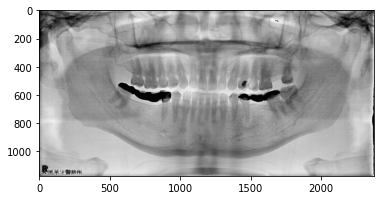

In [12]:
image_number = 1
image_names = list(data_dir.glob('*00006145.jpg'))
print(data_dir)

image_name = image_names[0]
filename = image_name.stem
im = cv2.imread(image_name)

plt.imshow(1 - im, cmap='gray')
plt.show()


D:\Users\douli\anaconda3\envs\dentist-CV-main\lib\site-packages\yolov5\utils\plots.py:475: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyxy = torch.tensor(xyxy).view(-1, 4)


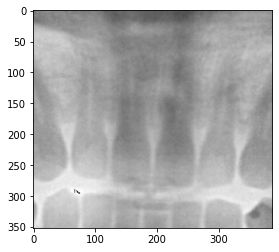

{'flag': 'upper',
 'number': 1,
 'tooth_position': 'middle',
 'org_file_name': '00006145',
 'offset': array([1013,  289]),
 'image': array([[[138, 138, 138],
         [132, 132, 132],
         [127, 127, 127],
         ...,
         [116, 116, 116],
         [114, 114, 114],
         [114, 114, 114]],
 
        [[143, 143, 143],
         [138, 138, 138],
         [133, 133, 133],
         ...,
         [116, 116, 116],
         [114, 114, 114],
         [112, 112, 112]],
 
        [[139, 139, 139],
         [139, 139, 139],
         [140, 140, 140],
         ...,
         [115, 115, 115],
         [113, 113, 113],
         [111, 111, 111]],
 
        ...,
 
        [[ 51,  51,  51],
         [ 44,  44,  44],
         [ 41,  41,  41],
         ...,
         [116, 116, 116],
         [117, 117, 117],
         [117, 117, 117]],
 
        [[ 51,  51,  51],
         [ 43,  43,  43],
         [ 39,  39,  39],
         ...,
         [112, 112, 112],
         [113, 113, 113],
         [112, 11

In [13]:
results = model(image_name)
teeth_roi = get_teeth_ROI(results)
teeth_roi_images = teeth_roi['images'][filename]
teeth_roi_split_teeth = teeth_roi['split_teeth']

target_roi = teeth_roi_images[1]
target_roi_image = target_roi['image']
flag = target_roi['flag']
tooth_position = tooth_position_dict[target_roi['number']]
im_g = cv2.cvtColor(target_roi_image, cv2.COLOR_RGBA2GRAY)
im_g_shape = np.array(np.array(im_g.shape)[[1, 0]])

plt.imshow(1 - im_g, cmap='gray')
plt.show()

target_roi


Erode to make gap bigger

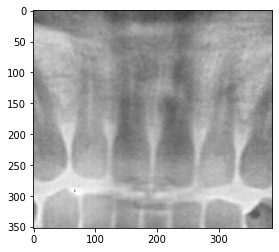

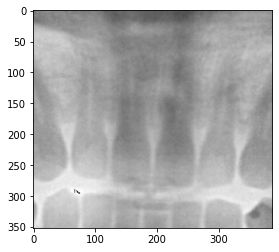

In [14]:
source = im_g
clahe = cv2.createCLAHE(clipLimit=0.6)

source = clahe.apply(source)

plt.gray()
plt.imshow(1 - source)
plt.show()

plt.gray()
plt.imshow(1 - im_g)
plt.show()


Rotate image to make tooth vertical

Zoom-in the crowns and discard the roots

135 295


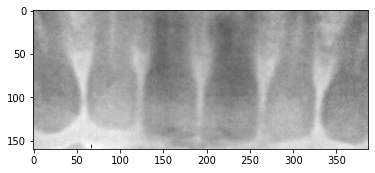

In [15]:
gum_sep_line, jaw_sep_line, hor_valleys, hor = gum_jaw_separation(source, flag=flag)

height, width = source.shape

if flag == 'upper':
    source_roi = source[gum_sep_line:jaw_sep_line, :]
    y1 = gum_sep_line
    y2 = jaw_sep_line
elif flag == 'lower':
    source_roi = source[jaw_sep_line:gum_sep_line, :]
    y1 = jaw_sep_line
    y2 = gum_sep_line
else:
    raise ValueError(f'flag only accept upper or lower but get {flag}.')

print(gum_sep_line, jaw_sep_line)

plt.imshow(1 - source_roi, cmap='gray')
plt.show()


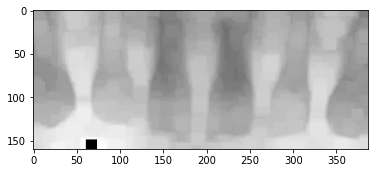

In [16]:
source_roi_filtered = source_roi
size = 5
kernel = np.ones((size, size), np.uint8)
source_roi_filtered = cv2.erode(source_roi_filtered, kernel, iterations=3)
# source_roi_filtered = gaussian_filter(source_roi_filtered, sigma=3)

plt.imshow(1 - source_roi_filtered)
plt.show()


[]


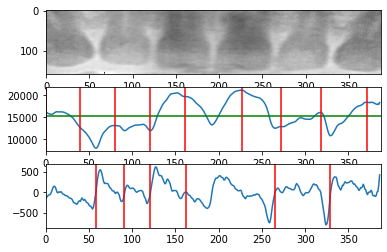

[ 58  91 121 162 265 329]


In [17]:
tooth_type = 'incisor' if tooth_position == 'middle' else 'molar'
window_position, valleys, ver, ver_slope = vertical_separation(source_roi, flag=flag, tooth_type=tooth_type)
# window_position, valleys, ver, ver_slope = vertical_separation(source_roi_filtered, flag=flag, tooth_type=tooth_type,
#                                                                angle=theta)

# Missing tooth detection
ver_mean = np.median(ver)
tooth_missing_region = []
for i in range(ver.shape[0] - 1):
    is_derivative_smooth = abs(ver_slope[i] - ver_slope[i + 1]) < 45
    curve_under_mean = ver[i] < ver_mean

    if is_derivative_smooth and curve_under_mean:
        tooth_missing_region.append(i)
tooth_missing_region = consecutive(tooth_missing_region)
tooth_missing_region = [(i[0], i[-1]) for i in tooth_missing_region if len(i) > 60]
print(tooth_missing_region)

# Delete redundant valley
peaks = []
for missing_region in tooth_missing_region:
    peaks, _ = find_peaks(ver_slope[missing_region[0]:missing_region[1]], height=0)
    if len(peaks) < 1 or ver_slope[peaks + missing_region[0]].max() > 100:
        continue

    valley_between_missing_tooth = ((missing_region[0] < valleys) & (valleys < missing_region[1]))
    valley_near_missing_tooth = np.logical_or(np.abs(valleys - missing_region[0]) < 20,
                                              np.abs(valleys - missing_region[1]) < 20)
    valley_need_delete = np.logical_or(valley_between_missing_tooth, valley_near_missing_tooth)

    valleys = valleys[~valley_need_delete]
    valleys = np.append(valleys, missing_region)

valleys.sort()
bounding_number = len(valleys) - 1

# Plot area
fig, axs = plt.subplots(3, 1)
axs[0].imshow(1 - source_roi, aspect='auto', cmap='gray')

height, width = source_roi.shape

axs[1].xaxis.set_ticks_position('bottom')
axs[1].set_xlim(xmin=0, xmax=width)
axs[1].plot(ver)
axs[1].axhline(y=ver_mean, color='g')
for p in window_position:
    axs[1].axvline(x=p, color='r')

axs[2].xaxis.set_ticks_position('bottom')
axs[2].set_xlim(xmin=0, xmax=width)
axs[2].plot(ver_slope)
if peaks:
    peaks += missing_region[0]
    axs[2].plot(peaks, ver_slope[peaks], "x")
for p in valleys:
    axs[2].axvline(x=p, color='r')

plt.show()
print(valleys)


In [18]:
rotation_fix = False

tooth_number_dict = all_tooth_number_dict[flag][tooth_position]
if flag == 'upper':
    y1, y2 = gum_sep_line // 2, jaw_sep_line
elif flag == 'lower':
    y1, y2 = jaw_sep_line, gum_sep_line * 2
else:
    raise ValueError(f'flag only accept upper or lower but get {flag}.')

unknown_counter = 50
crop_regions = {}
tooth_missing_left_bound = {i[0] for i in tooth_missing_region}

for missing_region in range(bounding_number):
    is_missing = valleys[missing_region] in tooth_missing_left_bound

    x1 = valleys[missing_region]
    x2 = valleys[missing_region + 1]
    xyxy = torch.Tensor([x1, y1, x2, y2])

    try:
        tooth_number = tooth_number_dict[missing_region]
    except KeyError:
        tooth_number = unknown_counter
        unknown_counter += 1

    # FIXME recovery_rotated_bounding broken
    crop_source = source
    shape_h, shape_w = source.shape
    xyxy = np.vstack([xyxy, xyxy])

    save_filename = f'{filename}-{tooth_number}'
    save_file = Path(f'./crops/{save_filename}.jpg')
    save = False
    crop_image = crop_by_xyxy(crop_source, xyxy.int(), save=save, file=save_file)
    crop_regions[tooth_number] = {'xyxy': xyxy, 'is_missing': is_missing, 'crop_image': crop_image}

# Plot bounding result
source_rgb = cv2.cvtColor(source, cv2.COLOR_GRAY2RGB)
annotator = Annotator(1 - source_rgb, line_width=3, example=filename)
for tooth_number, body in crop_regions.items():
    xyxy = body['xyxy']
    annotator.box_label(xyxy, str(tooth_number), color=(255, 0, 0))

im1 = annotator.result()

plt.imshow(im1)
plt.title(f'{filename}-{flag}-{tooth_position}')
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'int'

In [ ]:
for tooth_number, data in crop_regions.items():
    print(data)
    crop_image = data['crop_image']

    plt.imshow(1 - crop_image, cmap='gray')
    plt.title(tooth_number)
    plt.show()

